# We have point data for bicycle hire locations in London. But what if we wanted a dataset that allowed us to easily look up *routes* between them?

#### (Other Python geo notebooks are available at [https://github.com/urschrei/Geopython](https://github.com/urschrei/Geopython))

# Using Pandas and MapZen's free-to-use instance of OpenStreetMap's [Valhalla](https://mapzen.com/projects/valhalla) route lookup, we can accomplish this easily.

In [2]:
import requests
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
from shapely.geometry import mapping, Point, Polygon, LineString, MultiPolygon, box
from shapely.ops import unary_union
from descartes import PolygonPatch
mpl.rcParams['figure.figsize'] = (16, 12)
import math
import fiona
from itertools import chain, permutations, combinations
import json
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['savefig.dpi'] = 200

In [286]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

## Don't worry about the following 2 functions for now

In [37]:
def decode_polyline(point_str):
    """
    Decodes a polyline that has been encoded using Google's algorithm
    http://code.google.com/apis/maps/documentation/polylinealgorithm.html
    
    This is a generic method that returns a list of (lon, lat) 
    tuples.
    
    point_str: encoded polyline string
    returns: list of 2-tuples, (lon, lat)
    """
    # some coordinate offsets are represented by 4 to 5 binary chunks
    if pd.isnull(point_str):
        return np.nan
    coord_chunks = [[]]
    for char in point_str:
        # convert each character to decimal from ascii
        value = ord(char) - 63
        # values that have a chunk following have an extra 1 on the left
        split_after = not (value & 0x20)   
        value &= 0x1F
        coord_chunks[-1].append(value)
        if split_after:
            coord_chunks.append([])
    del coord_chunks[-1]
    coords = []
    for coord_chunk in coord_chunks:
        coord = 0
        for i, chunk in enumerate(coord_chunk):               
            coord |= chunk << (i * 5)
        # there is a 1 on the right if the coord is negative
        if coord & 0x1:
            coord = ~coord #invert
        coord >>= 1
        # https://github.com/Project-OSRM/osrm-backend/issues/713
        # (OSRM returns higher-precision coordinates)
        coord /= 1000000.
        coords.append(coord)
    # convert the 1d list to a 2d list & offsets to actual values
    points = []
    prev_x = 0
    prev_y = 0
    for i in xrange(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue
        prev_x += coords[i + 1]
        prev_y += coords[i]
        # rounding to 6 digits ensures that the floats are the same as when 
        # they were encoded
        points.append((round(prev_x, 6), round(prev_y, 6)))
    if len(points) > 1:
        return LineString(points)
    else:
        return np.nan

#### This function accepts start and end points, and a transport mode, and retrieves a route from MapZen's OSRM endpoint.

In [38]:
def query_routing_machine(start, end, method):
    """
    Get a route back from MapZen's OSRM
    start, end: lon, lat tuples
    method: foot, car, bicycle
    returns encoded Polyline
    TODO: bounds checking for coords
    """
    allowed = ('foot', 'car', 'bicycle')
    if method not in allowed:
        raise Exception(
            "Unknown method. Must be one of %s. Christ." % ', '.join(allowed))
    endpoint = 'http://osrm.mapzen.com'
    method = '/{m}/viaroute'.format(m=method)
    # should be properly encoding second loc, but dict keys are unique!
    # reverse lon, lat because ugh    
    params = {'loc': '{1},{0}&loc={3},{2}'.format(*chain(start, end))}
    req = requests.get(endpoint + method, params=params)
    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError:
        return np.nan
    return req.json()['route_geometry']

In [ ]:
def query_routing_machine(start, end, costing, key, *args):
    """
    Query a Valhalla instance for a route
    Not all options have been implemented here.
    See: https://github.com/valhalla/valhalla-docs/blob/gh-pages/api-reference.md#inputs-of-a-valhalla-route
    """
    allowed = ('pedestrian', 'bicycle', 'bus', 'auto', 'auto_shorter')
    if costing not in allowed:
        raise Exception(
            "Unknown method. Must be one of %s. Christ." % ', '.join(allowed))
    
    # build routing JSON
    initial_route = {
        "locations": [{"lat":start[1] ,"lon": start[0]}, {"lat":end[1] ,"lon":end[0]}],
        "costing": costing,
        "directions_options": {"units": "kilometers"}
    }
    route = initial_route.copy()
    if args:
        route.update(args)
    endpoint = "https://valhalla.mapzen.com/route"
    params = {"json": json.dumps(route), "api_key": key}
    req = requests.get(endpoint, params=params)
    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError:
        return np.nan
    if req.json()['trip']['status'] == 207:
        return np.nan
    return req.json()['trip']['route_geometry']

# This is our raw station data

In [39]:
nodes = pd.read_csv('data/nodes_london.csv', header=None, names=['name', 'lat', 'lon'])
nodes.head()

,name,lat,lon
10108,Abbey Orchard Street,51.498126,-0.132102
10394,Aberdeen Place,51.524826,-0.176268
10038,Abingdon Villas,51.497388,-0.197246
10100,Albert Embankment,51.490436,-0.122807
10303,Albert Gate,51.502954,-0.158456


(There are over 700 stations now, this dataset contains a mere 406)

## For the sake of convenience, let's combine lon and lat points into a tuple

In [40]:
nodes['coords'] = zip(nodes['lon'], nodes['lat'])
nodes = nodes.set_index('name')
nodes.head()

,lat,lon,coords
name,,,
Abbey Orchard Street,51.498126,-0.132102,"(-0.132102166, 51.49812559)"
Aberdeen Place,51.524826,-0.176268,"(-0.176268, 51.524826)"
Abingdon Villas,51.497388,-0.197246,"(-0.197245586, 51.4973875)"
Albert Embankment,51.490436,-0.122807,"(-0.122806861, 51.49043573)"
Albert Gate,51.502954,-0.158456,"(-0.158456089, 51.50295379)"


## If we wanted to get every route in this dataset, we'd have to perform 164,836 calls to MapZen's [Valhalla instance](https://mapzen.com/projects/valhalla).     That might be a bit much, so let's use a subset for this demo

In [41]:
nodes = nodes[:20]
nodes

,lat,lon,coords
name,,,
Abbey Orchard Street,51.498126,-0.132102,"(-0.132102166, 51.49812559)"
Aberdeen Place,51.524826,-0.176268,"(-0.176268, 51.524826)"
Abingdon Villas,51.497388,-0.197246,"(-0.197245586, 51.4973875)"
Albert Embankment,51.490436,-0.122807,"(-0.122806861, 51.49043573)"
Albert Gate,51.502954,-0.158456,"(-0.158456089, 51.50295379)"
Alderney Street,51.488058,-0.140741,"(-0.140741432, 51.48805753)"
Aldersgate Street,51.520842,-0.097340,"(-0.097340162, 51.5208417)"
Alfred Place,51.519656,-0.132339,"(-0.132339, 51.519656)"
Altab Ali Park,51.516816,-0.067828,"(-0.067827542, 51.51681603)"


## In order to easily query our routes, we need to form a square DataFrame, with identical columns and Index

### We're filling the DataFrame with zeros to begin with, in order to get the right shape

In [42]:
square = pd.DataFrame(
    np.zeros(len(nodes) ** 2).reshape(len(nodes), len(nodes)),
    index=nodes.index, columns=nodes.index)
square.head()

name,Abbey Orchard Street,Aberdeen Place,Abingdon Villas,Albert Embankment,Albert Gate,Alderney Street,Aldersgate Street,Alfred Place,Altab Ali Park,Ampton Street,Appold Street,Argyll Road,Ashley Place,Baker Street,Baldwin Street,Bank of England Museum,Bankside Mix,Barbican Centre,Bath Street,Bayley Street
name,,,,,,,,,,,,,,,,,,,,
Abbey Orchard Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aberdeen Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abingdon Villas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Albert Embankment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Albert Gate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## This next part is slightly complex…bear with me

#### This function looks up our 'end' coordinates from the `nodes` DataFrame using the input column name, then applies the `query_routing_machine()` function to each row in the input column, using the `nodes` `coords` column as the first argument. This works because the function is applied column-wise from right to left. Single-point routes are replaced with `NaN`.

In [43]:
api_key = 'your_valhalla_api_key'

def get_routes(col):
    """
    retrieve coords from nodes df
    pass to query_routing_machine()
    """
    end = nodes.ix[col.name]['coords']
    ns = nodes['coords'].apply(query_routing_machine, end=end, costing='bicycle', key=api_key)
    return ns

We're transposing the DataFrame (`.T`), because the `loc[]` method we'll be using to retrieve routes refers to `index label, row label`. However, because our inner `appply` function (see above) populates a *column* with retrieved values, our lookup would return destination --> origin linestrings if we didn't transpose our results.

In [9]:
routes = square.apply(get_routes, axis=1).T
routes

name,Abbey Orchard Street,Aberdeen Place,Abingdon Villas,Albert Embankment,Albert Gate,Alderney Street,Aldersgate Street,Alfred Place,Altab Ali Park,Ampton Street,Appold Street,Argyll Road,Ashley Place,Baker Street,Baldwin Street,Bank of England Museum,Bankside Mix,Barbican Centre,Bath Street,Bayley Street
name,,,,,,,,,,,,,,,,,,,,
Abbey Orchard Street,odefaBt{`G??,odefaBt{`GzEtPmJNqLzJp\rqAvBbIdAtGjLlr@rCv[t@b...,odefaBt{`GzEtPmJNqLzJp\rqAvBbIdAtGjLlr@rCv[t@b...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@~JmBlI}CtQgStQcC...,odefaBt{`GzEtPmJNqLzJp\rqAvBbIdAtGjLlr@rCv[t@b...,odefaBt{`GzEtPbK`BhCMzJg@hj@cMb@|DjBlOzDvf@hBt...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GzEtPmJNqLzJp\rqAvBbIdAtGjLlr@rCv[t@b...,NaN,NaN,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...,odefaBt{`GeLwb@]kQc@iUO_IiCoi@yo@mMoENgBbBiBhB...
Aberdeen Place,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI??,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,NaN,NaN,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...,wnygaBvjwI_FaMvBcBpK}Obo@ccAgWy[jOq^pXsp@fL_Xj...
Abingdon Villas,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CwI}\...,o{cfaBlg`K??,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAiTo{A}Du_@ha@sNfF_E`F{DnI_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CwI}\...,NaN,NaN,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...,o{cfaBlg`KeQyiAwLcjAmo@p[qFvCgm@vZ}TrK{C|CqJi_...
Albert Embankment,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF??,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,NaN,NaN,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...,wdveaBllnF_f@kP}d@ePyD{@wF{AoKkC_JBgD_A_HiBkCq...
Albert Gate,gunfaBfotHjHw@[wKMcLEsMaFslAwCmx@YsGqBsg@}Boe@...,gunfaBfotHjHw@[wKMcLEsMaFslAwCmx@YsGqBsg@}Boe@...,g

We could have performed the decoding step and converted the result to a `LineString` instance in `get_routes()`, above, but this is more flexible: we can trivially dump our DataFrame to e.g. CSV, and keep the encoded polyline data intact.

In [10]:
routes.to_csv('data/journeys_encoded.csv')

In order to convert the routes to LineStrings, we apply the `decode_polyline()` function across our DataFrame:

In [46]:
routes = routes.applymap(decode_polyline)
# you could optionally convert to geoJSON:
# routes.applymap(lambda(x): json.dumps(mapping(x)) if not pd.isnull(x) else np.nan)

## Now we have a big square DataFrame, filled with decoded Valhalla routes

### Retrieving the route for a given origin / destination pair is now trivial:

In [47]:
# give an origin and destination to .loc[]
list(routes.loc['Abbey Orchard Street', 'Albert Gate'].coords)

[(-0.132043, 51.498072),
 (-0.132326, 51.497962),
 (-0.132334, 51.498145),
 (-0.132524, 51.498362),
 (-0.133846, 51.497889),
 (-0.134008, 51.497829),
 (-0.134147, 51.497794),
 (-0.13497, 51.49758),
 (-0.13543, 51.497506),
 (-0.135624, 51.497479),
 (-0.135648, 51.497565),
 (-0.135673, 51.497613),
 (-0.135776, 51.497816),
 (-0.135904, 51.497976),
 (-0.136017, 51.498107),
 (-0.136164, 51.498236),
 (-0.136351, 51.498361),
 (-0.136492, 51.498438),
 (-0.137049, 51.498675),
 (-0.137126, 51.498707),
 (-0.137344, 51.498788),
 (-0.13787, 51.498991),
 (-0.137947, 51.499024),
 (-0.138133, 51.499081),
 (-0.138654, 51.499235),
 (-0.139485, 51.499513),
 (-0.139797, 51.499608),
 (-0.14018, 51.499736),
 (-0.140343, 51.499809),
 (-0.140773, 51.500081),
 (-0.140933, 51.500187),
 (-0.140884, 51.500299),
 (-0.140827, 51.500421),
 (-0.140547, 51.500973),
 (-0.140479, 51.501098),
 (-0.14045, 51.501258),
 (-0.140197, 51.501586),
 (-0.139992, 51.501814),
 (-0.139998, 51.501896),
 (-0.140022, 51.501967),
 (-0.1

# Let's map these

### Setting up some map parameters

In [4]:
shp = fiona.open('data/london_wards.shp')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

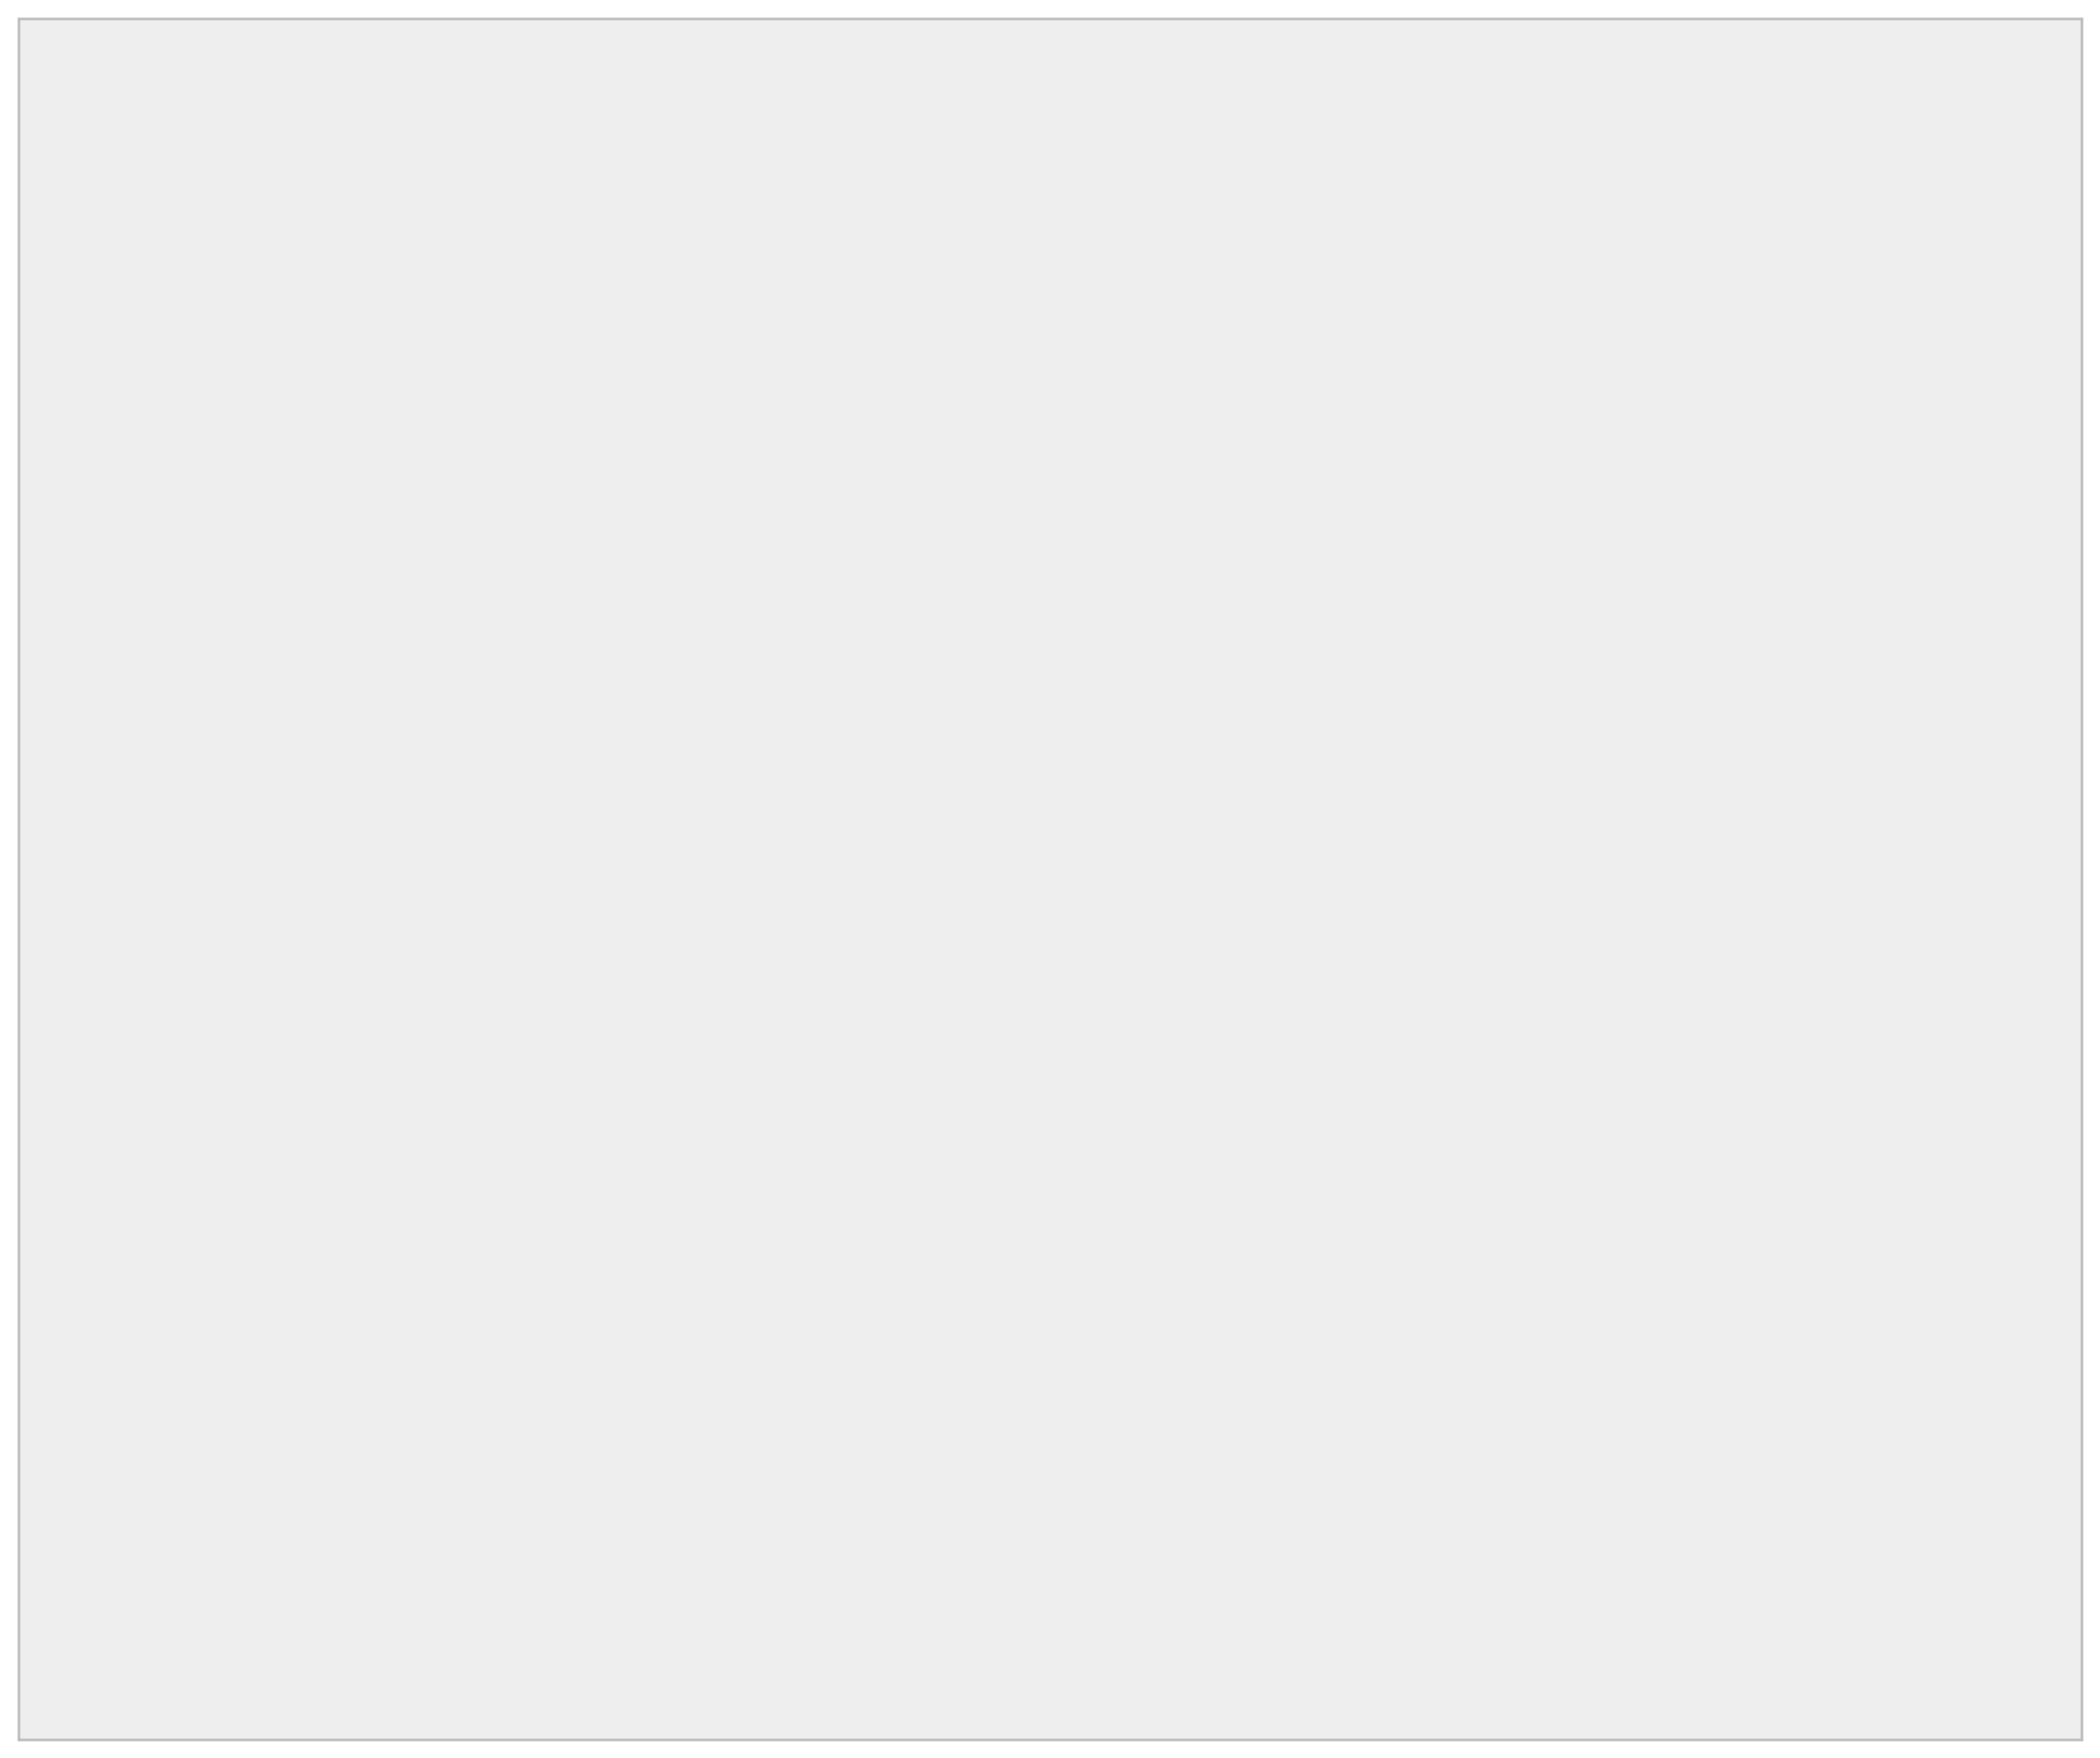

In [5]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/london_wards',
    'london',
    color='none',
    zorder=2)
thames = m.readshapefile(
    'data/thames_wgs84',
    'thames',
    color='none',
    zorder=3)

In [50]:
# cascade ward polygons together
london_poly = unary_union([Polygon(xy) for xy in m.london])

## In order to plot our linestrings on a map, we first have to convert them to projected coordinates

In [51]:
def project_linestring(ls, inverse=False):
    """ return a linestring projected into map coordinates """
    if not pd.isnull(ls):
        return LineString(zip(*m(*zip(*ls.coords))))
    else:
        return np.nan

### Yes, a lot happens in the `add_collection` call, but it's just perfunctory element-wise function application, flattening the result into a 1-dimensional array, converting LineStrings into patches, and then plotting them.

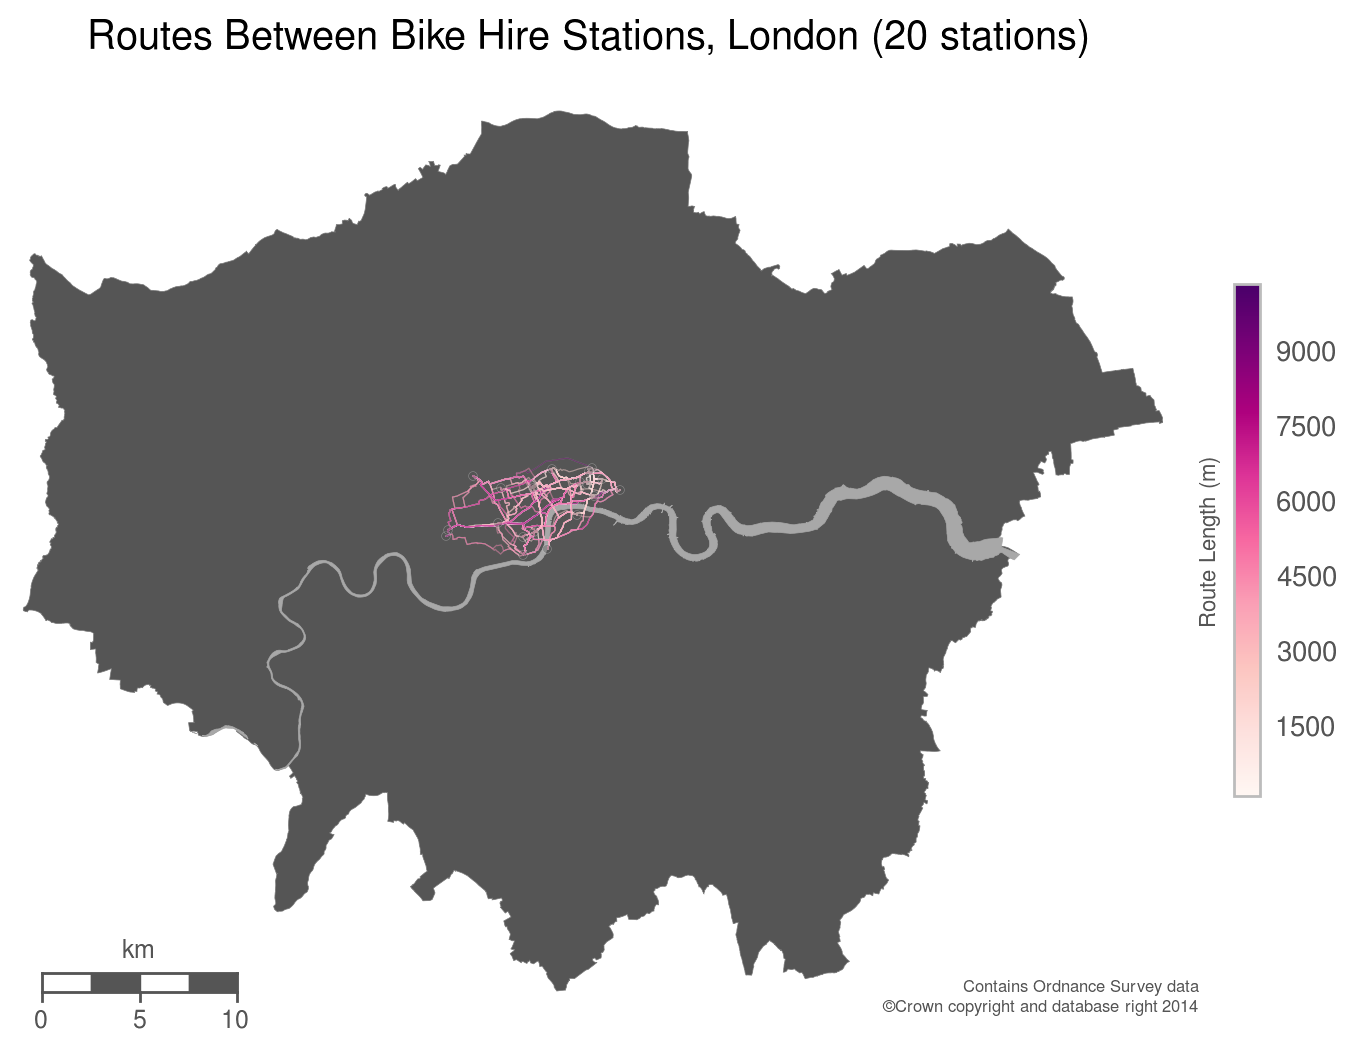

In [292]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

# plot London outline
lp = PolygonPatch(
    london_poly,
    fc='#555555', ec='#787878', lw=.25, alpha=1., zorder=2)
ax.add_patch(lp)

# project linestrings, melt dataframe into series, buffer linestring values, build patches
lines = [line for line in pd.melt(routes.applymap(project_linestring)).dropna()['value']]

pc = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in lines],
    match_original=False, alpha=.5, color='#7F00FF', lw=.05, zorder=4)

# impose a colormap. Longer lines are darker
norm = Normalize()
cmap = plt.get_cmap('RdPu')
pc.set_facecolor(cmap(norm([line.length for line in lines])))
pc.set_edgecolors('#ffffff')
ax.add_collection(pc)

# tediously construct a colour bar
sm = ScalarMappable(cmap=cmap, norm=Normalize(
    vmin=min([line.length for line in lines]),
    vmax=max(([line.length for line in lines]))))
# urgh
sm.set_array([])
cbar = plt.colorbar(sm, shrink=.5)
cbar.set_label("Route Length (m)", size=8, labelpad=-50)

# cascade thames polygons together
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#a8a8a8', lw=.25, alpha=1., zorder=3)
ax.add_collection(tp)

# scatter plot of first 20 station locations
m.scatter(
    *zip(m(*zip(*nodes['coords'][:20]))),
    s=10, zorder=5, lw=.2,
    color='#545454', edgecolor='#ffffff', alpha=.35)

# We need to reproduce the OS Data copyright licence
smallprint = ax.text(
    1.03, 0,
    r'\begin{flushright}Contains Ordnance Survey data\\\copyright~Crown copyright and database right 2014\end{flushright}',
    ha='right', va='bottom',
    size=6,
    color='#555555',
    transform=ax.transAxes,
)

m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.0085,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.title("Routes Between Bike Hire Stations, London (%s stations)" % len(routes))
plt.tight_layout()
fig.set_size_inches(7.28, 5.25)
plt.savefig('data/london_bike_routes.png', dpi=300, bbox_inches='tight', alpha=True, transparent=True)
plt.show()

## Computing basic statistics is straightforward:

In [17]:
lines = pd.melt(routes.applymap(project_linestring)).dropna()
lines['length'] = lines['value'].apply(lambda x: x.length)

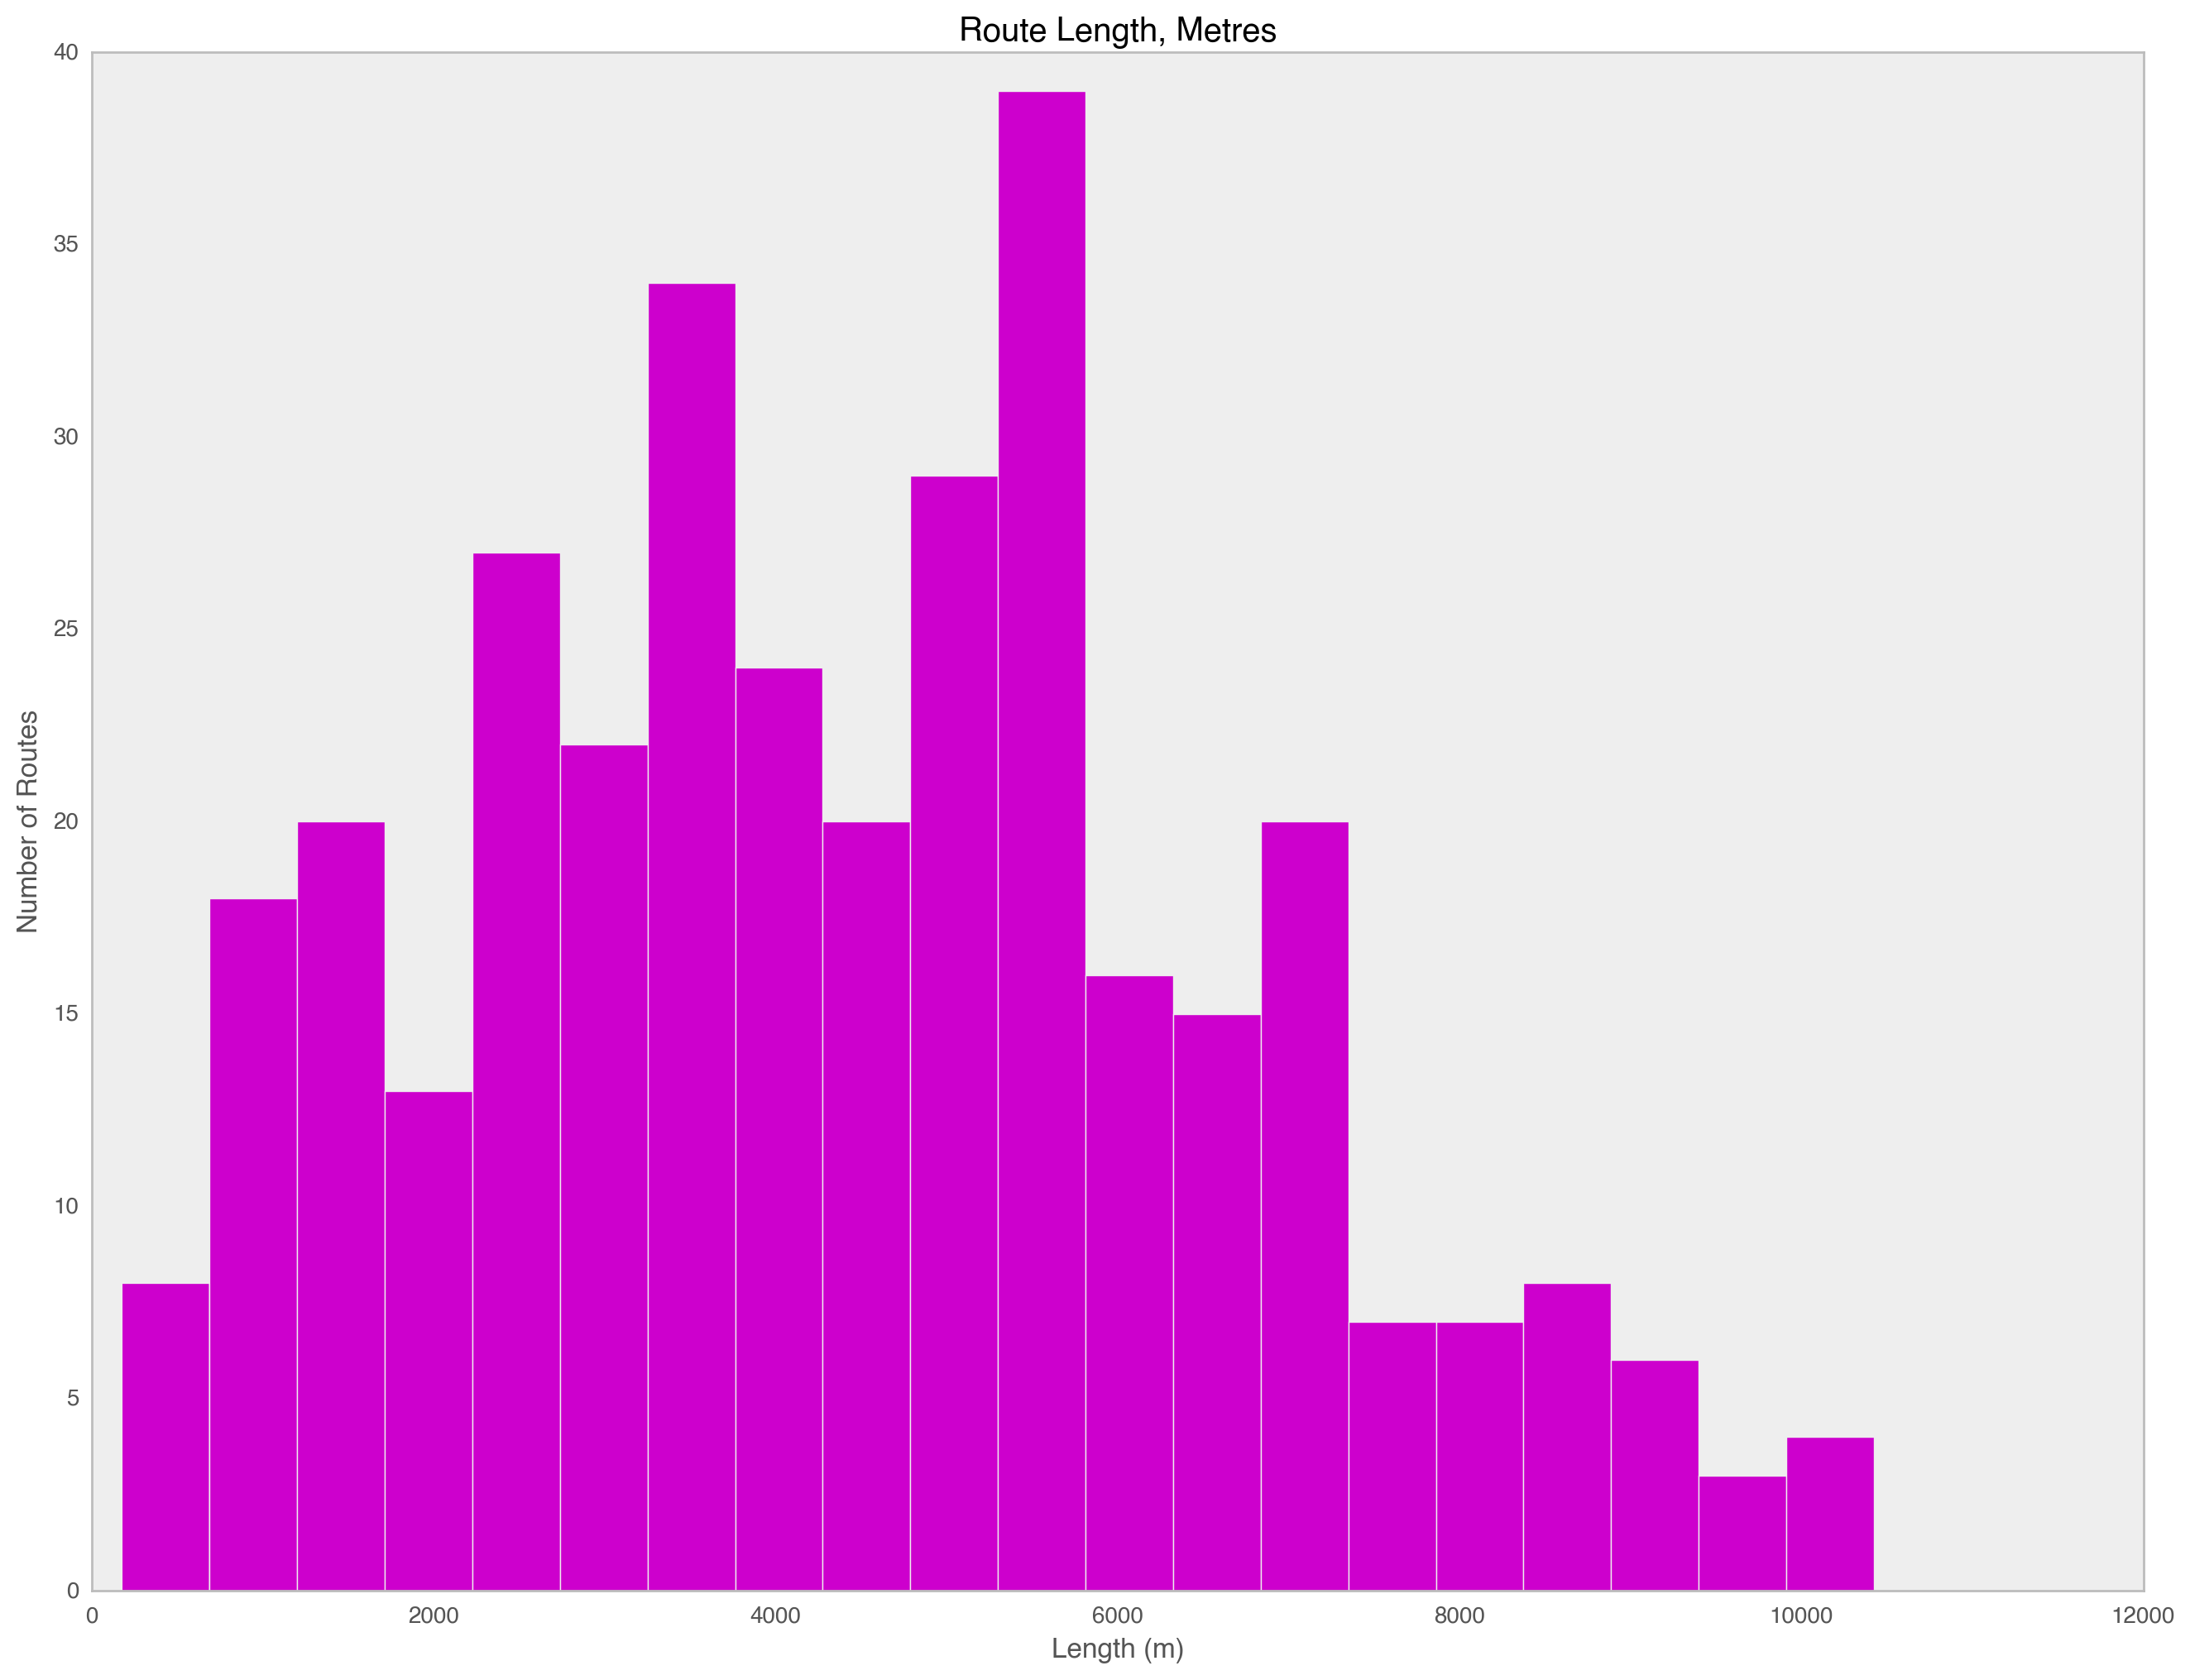

In [18]:
histax = lines['length'].plot(
    kind='hist',
    bins=20, color='#CD00CD',
    title='Route Length, Metres')
histax.set_xlabel('Length (m)')
histax.set_ylabel('Number of Routes')
histax.grid(None)

# Other Interesting Things You Could Do Using This Approach

- The OSRM queries return a lot of information – I'm just returning the routes, but there's a lot more available. You could use the returned travel time data to create and map isochrones (I love isochrones)
- A complete data set could be used as the basis for some interesting network analysis:
    - You could use it to construct a routable network graph using e.g. [NetworkX](https://networkx.github.io) or [Pandana](https://github.com/synthicity/pandana)
    - It would be trivial to determine the most frequently-used route segments (Shapely has a nice `equals()` function for this, allowing you to easily bin and then rank the most frequently-occurring segments). This is a brute-force approach, though…
    - Because [betweeness centrality](http://en.wikipedia.org/wiki/Betweenness_centrality) exists
- This type of analysis could serve as the basis for safety improvements (and/or emission reduction) for that segment  
- In a utopian future in which transit agencies are receptive and responsive to that sort of thing, I mean.

### Let's brute-force it for fun

In [21]:
def segmentise(col):
    """
    Returns a column of line segments for each input line segment
    i.e. this decomposes segments (routes) into their smallest components
    """
    
    def pair(ls):
        """ return an iterator over pairs in a list -> pair of points """
        for i in range(1, len(ls)):
            yield ls[i-1], ls[i]

    segments = []
    for seg_start, seg_end in pair(col.coords):
        line_start = Point(seg_start)
        line_end = Point(seg_end)
        segment = LineString([line_start.coords[0], line_end.coords[0]])
        segments.append(segment)
    return pd.Series(segments)

In [27]:
pairs = lines['value'].apply(segmentise).T

In [23]:
route_segments = pd.melt(pairs).dropna()

In [24]:
route_segments.head()

,variable,value
0,0,LINESTRING (23219.74400711304 27686.6792727442...
1,0,LINESTRING (21841.8977976843 24597.64067275674...
2,0,LINESTRING (27046.88549121862 23947.0635252556...
3,0,LINESTRING (24519.6490177736 25280.09931192154...
4,0,LINESTRING (25791.82129012587 23653.2107669302...


In [130]:
# string-encode coords for comparison (ugh)
route_segments['decoded'] = route_segments.value.apply(lambda x: ''.join(str(seq) for seq in (list(chain(*x.coords)))))
route_segments.head()

,variable,value,start_point,decoded
0,0,LINESTRING (23219.74400711304 27686.6792727442...,"(23219.7440071, 27686.6792727)",23219.744007127686.679272723235.047225627699.5...
1,0,LINESTRING (21841.8977976843 24597.64067275674...,"(21841.8977977, 24597.6406728)",21841.897797724597.640672821924.215668524632.0...
2,0,LINESTRING (27046.88549121862 23947.0635252556...,"(27046.8854912, 23947.0635253)",27046.885491223947.063525327064.410915924016.9...
3,0,LINESTRING (24519.6490177736 25280.09931192154...,"(24519.6490178, 25280.0993119)",24519.649017825280.099311924522.012902425263.4...
4,0,LINESTRING (25791.82129012587 23653.2107669302...,"(25791.8212901, 23653.2107669)",25791.821290123653.210766925782.678520923660.2...


In [138]:
# value_counts.idxmax only works on something that isn't an object or a sequence
route_segments['decoded'].value_counts()

27091.392195927152.600028327104.333827127165.177444     43
27076.905653327137.97924627091.392195927152.6000283     43
26706.527108525122.315344126723.635516625121.6400429    40
27346.640530927310.889405527357.682358227316.2942407    36
27238.478418327263.57954227305.568133627293.1347641     36
27158.610406627217.778333827171.339854127227.7901634    36
27397.358455727337.018967227433.605918127350.6426513    36
27143.93970727204.933701527158.610406627217.7783338     36
27184.109283227236.244599627202.179706227246.5051155    36
27171.339854127227.790163427184.109283227236.2445996    36
27202.179706227246.505115527238.478418327263.579542     36
27131.015426527191.688712627143.93970727204.9337015     36
27305.568133627293.134764127346.640530927310.8894055    36
27381.426501427330.041011627397.358455727337.0189672    36
27104.333827127165.17744427131.015426527191.6887126     36
...
23682.961576724225.447107823744.068130824221.5201328    1
25289.756423524137.842206725351.326958624285.8924872 

In [139]:
# most common line segment coords
most_common = list(route_segments[route_segments.decoded == '27091.392195927152.600028327104.333827127165.177444'].iloc[0].value.coords)
most_common

[(27091.392195923574, 27152.600028321176), (27104.3338271494, 27165.177443989)]

In [140]:
# pythagoras works on mercator
xdiff = abs(most_common[0][0] - most_common[1][0]) ** 2
ydiff = abs(most_common[0][1] - most_common[1][1]) ** 2
# segment length, in metres
math.sqrt(xdiff + ydiff)

18.04652885367354

### Junction of Theobald's Road and Old Gloucester Street - Plausible

In [141]:
json.dumps(mapping(LineString(zip(*m(*zip(*most_common), inverse=True)))))

'{"type": "LineString", "coordinates": [[-0.12075799999842438, 51.51918199999574], [-0.12056699999842416, 51.51929199999574]]}'